# 1. Receptive field and parameter count (1 point)

Recall that the *receptive field* refers to size of the region in the input that are visible to a given activation (or neuron) in a convolutional neural network. "Visible" here means that the values of those inputs affect the value of the activation. In all of the following questions, assume that the input image is arbitrarily large, so you don't need to worry about boundary effects or padding.

1. Consider a convolutional network which consists of three convolutional layers, each with a filter size of 3x3, and a stride of 1x1. What is the receptive field size of one of the activations at the final output?
1. What is the receptive field if the stride is 2x3 at each layer?
1. What is the receptive field if the stride is 2x2 at each layer, and there is a 2x2 max-pooling layer with stride 2x2 after each convolutional layer?
1. Assume that the input image has 3 channels, the three convolutional layers have 16, 32, and 64 channels respectively, and that there are no biases on any of the layers. How many parameters does the network have?

References for Mathematical Formulas used in Problem 1:
Problem 1.1 and 1.2: https://distill.pub/2019/computing-receptive-fields/
Problem 1.3: https://gist.github.com/Nikasa1889/781a8eb20c5b32f8e378353cde4daa51#file-computereceptivefield-py 
Problem 1.4: https://www.youtube.com/watch?v=gmBfb6LNnZs 

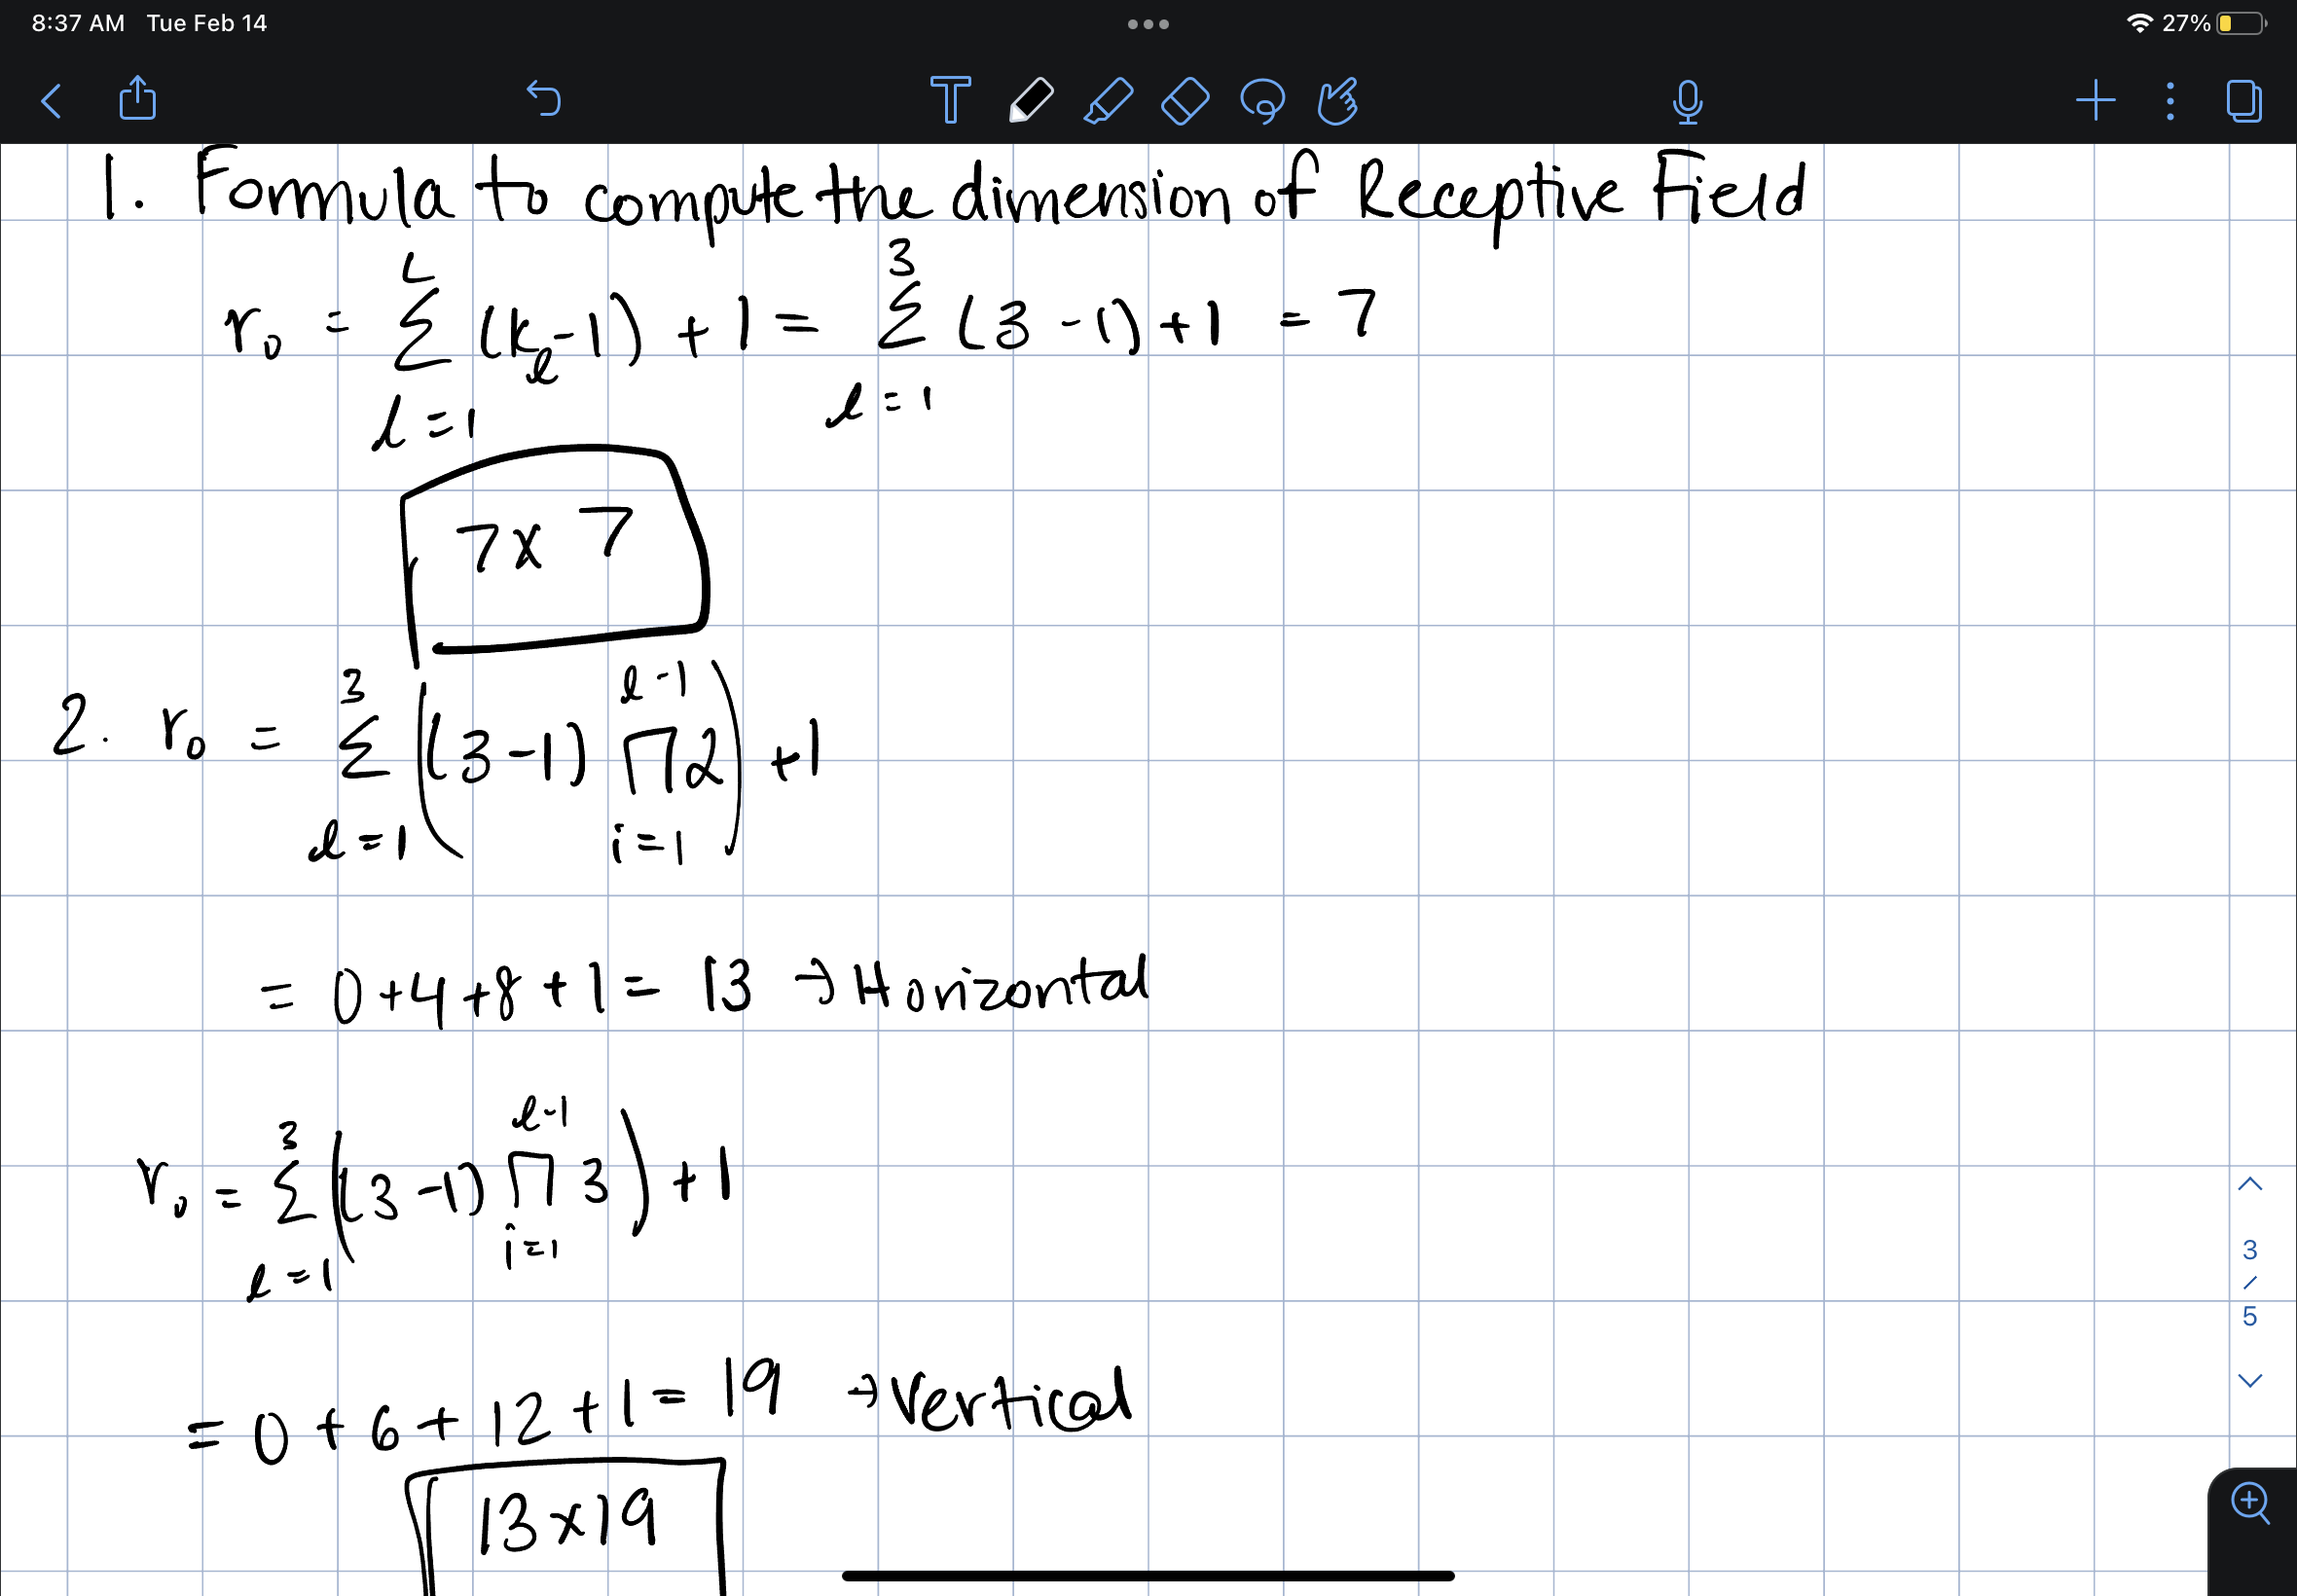

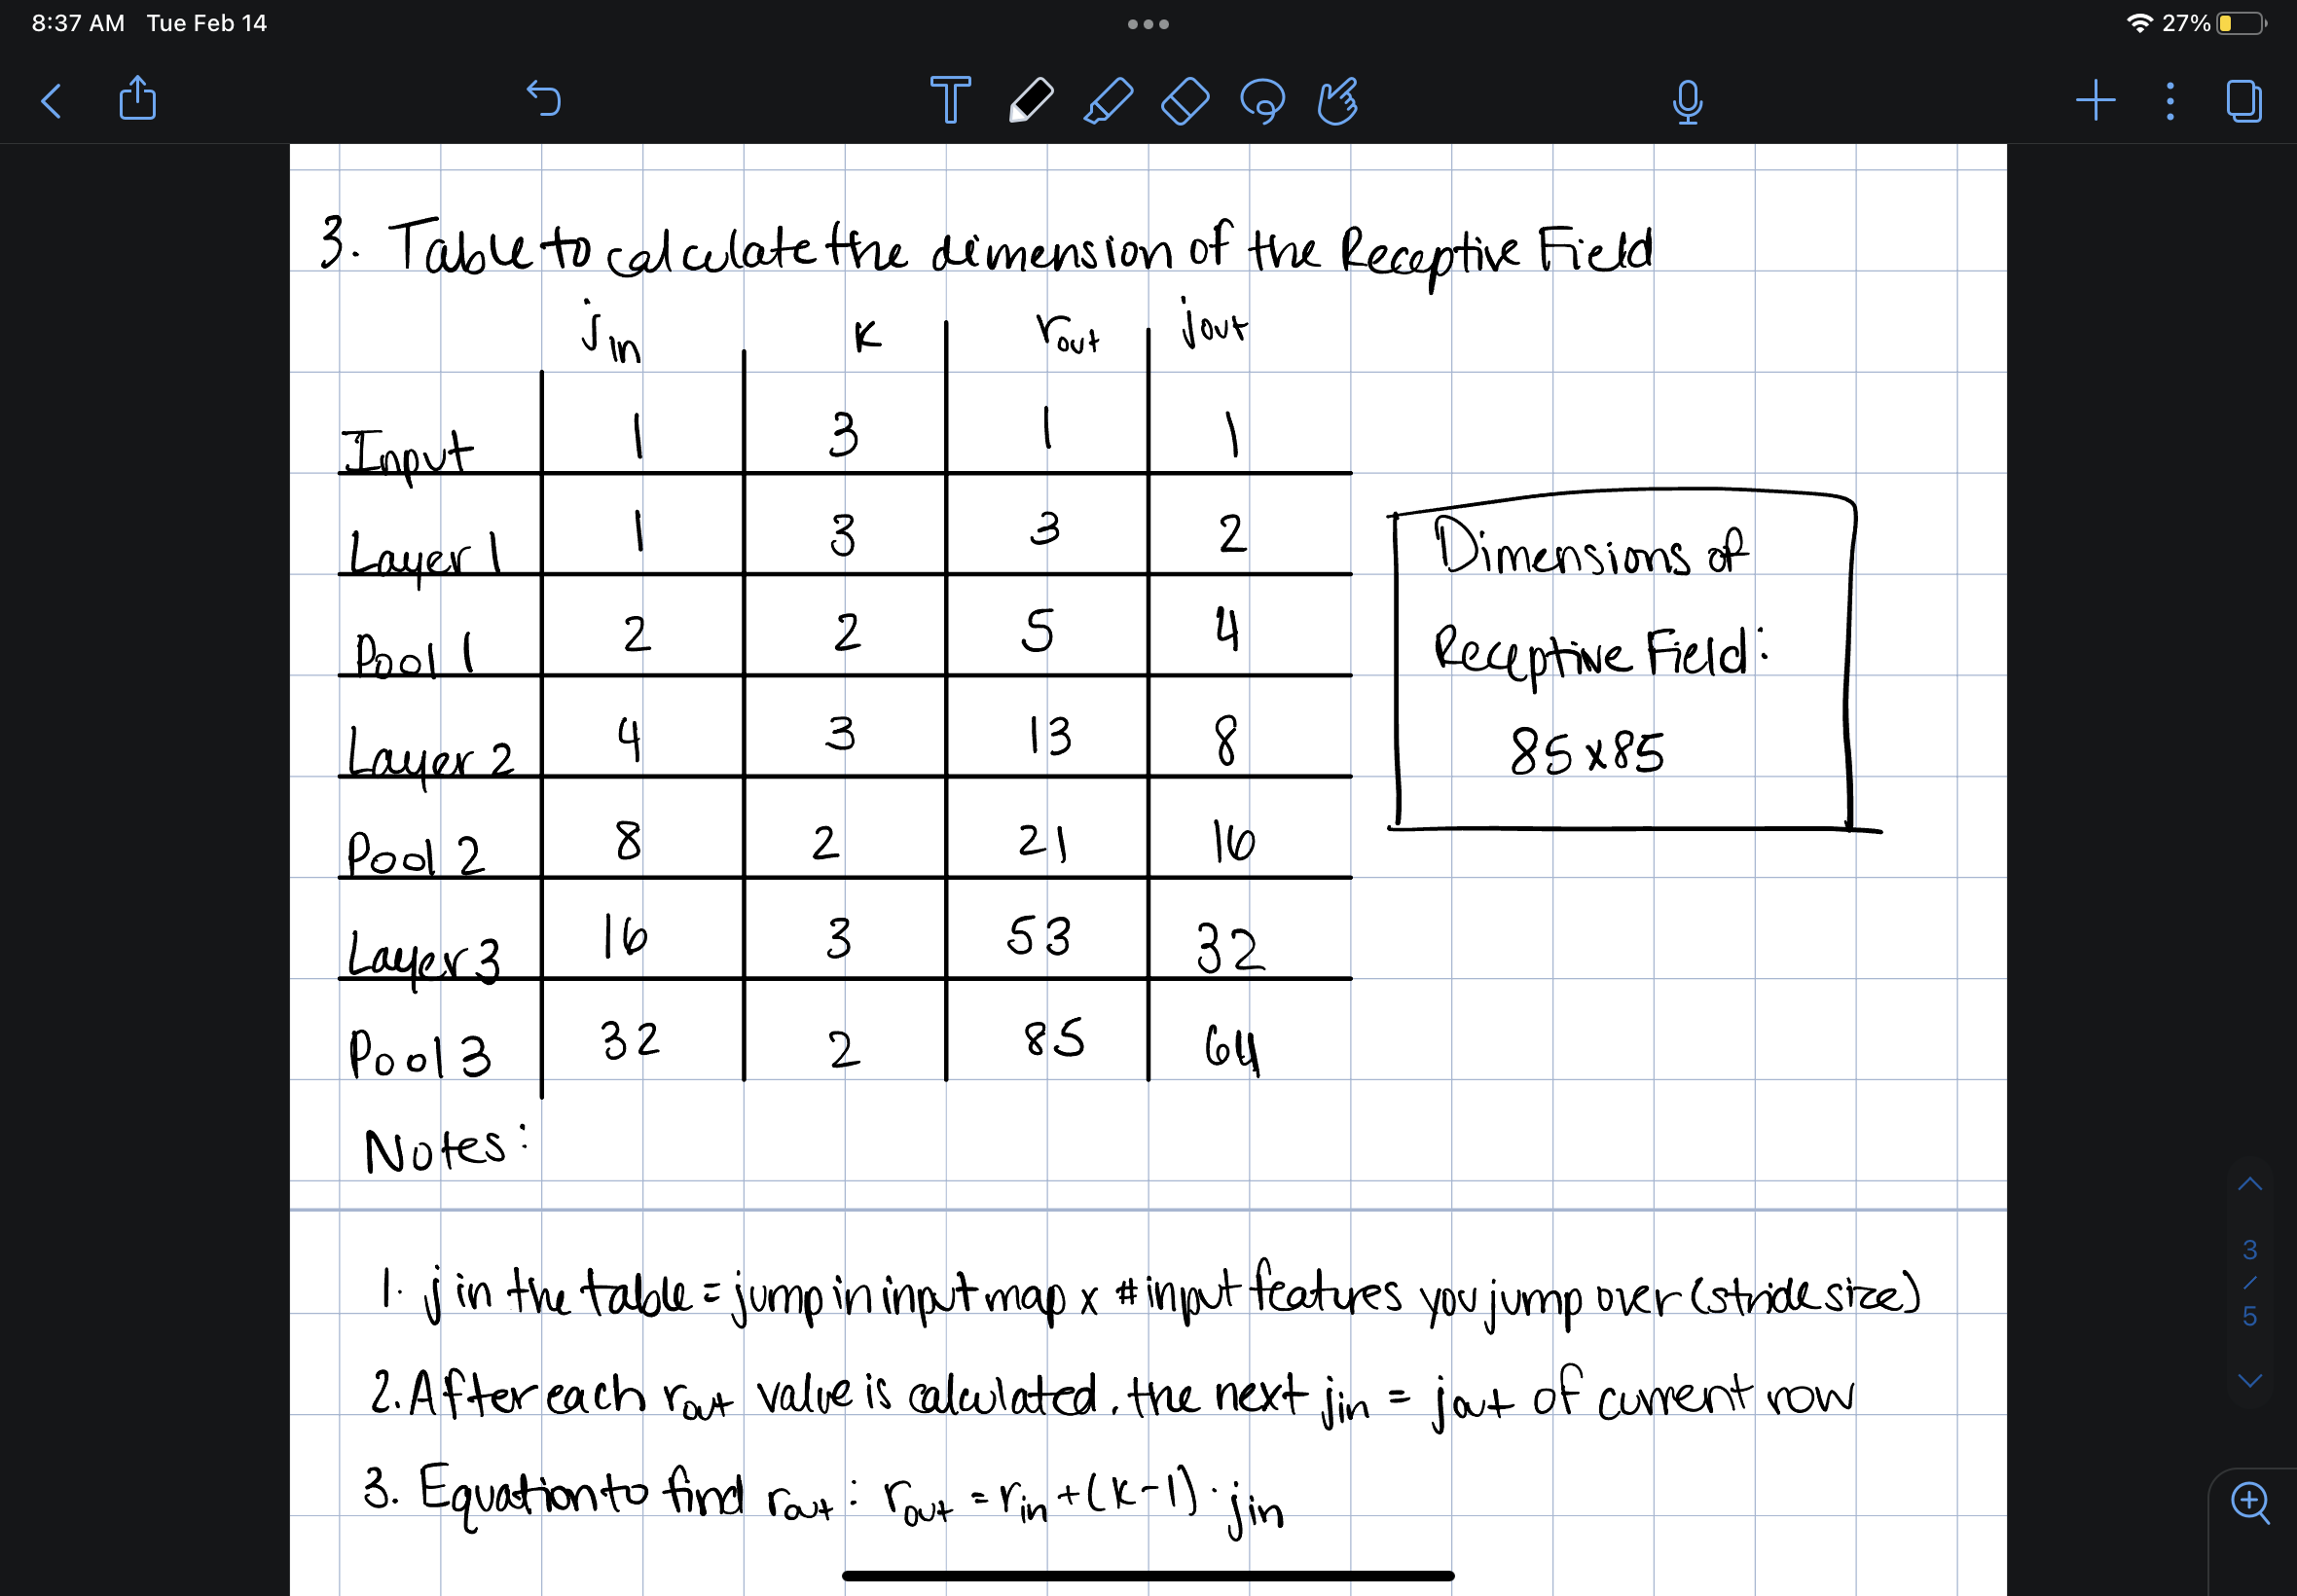

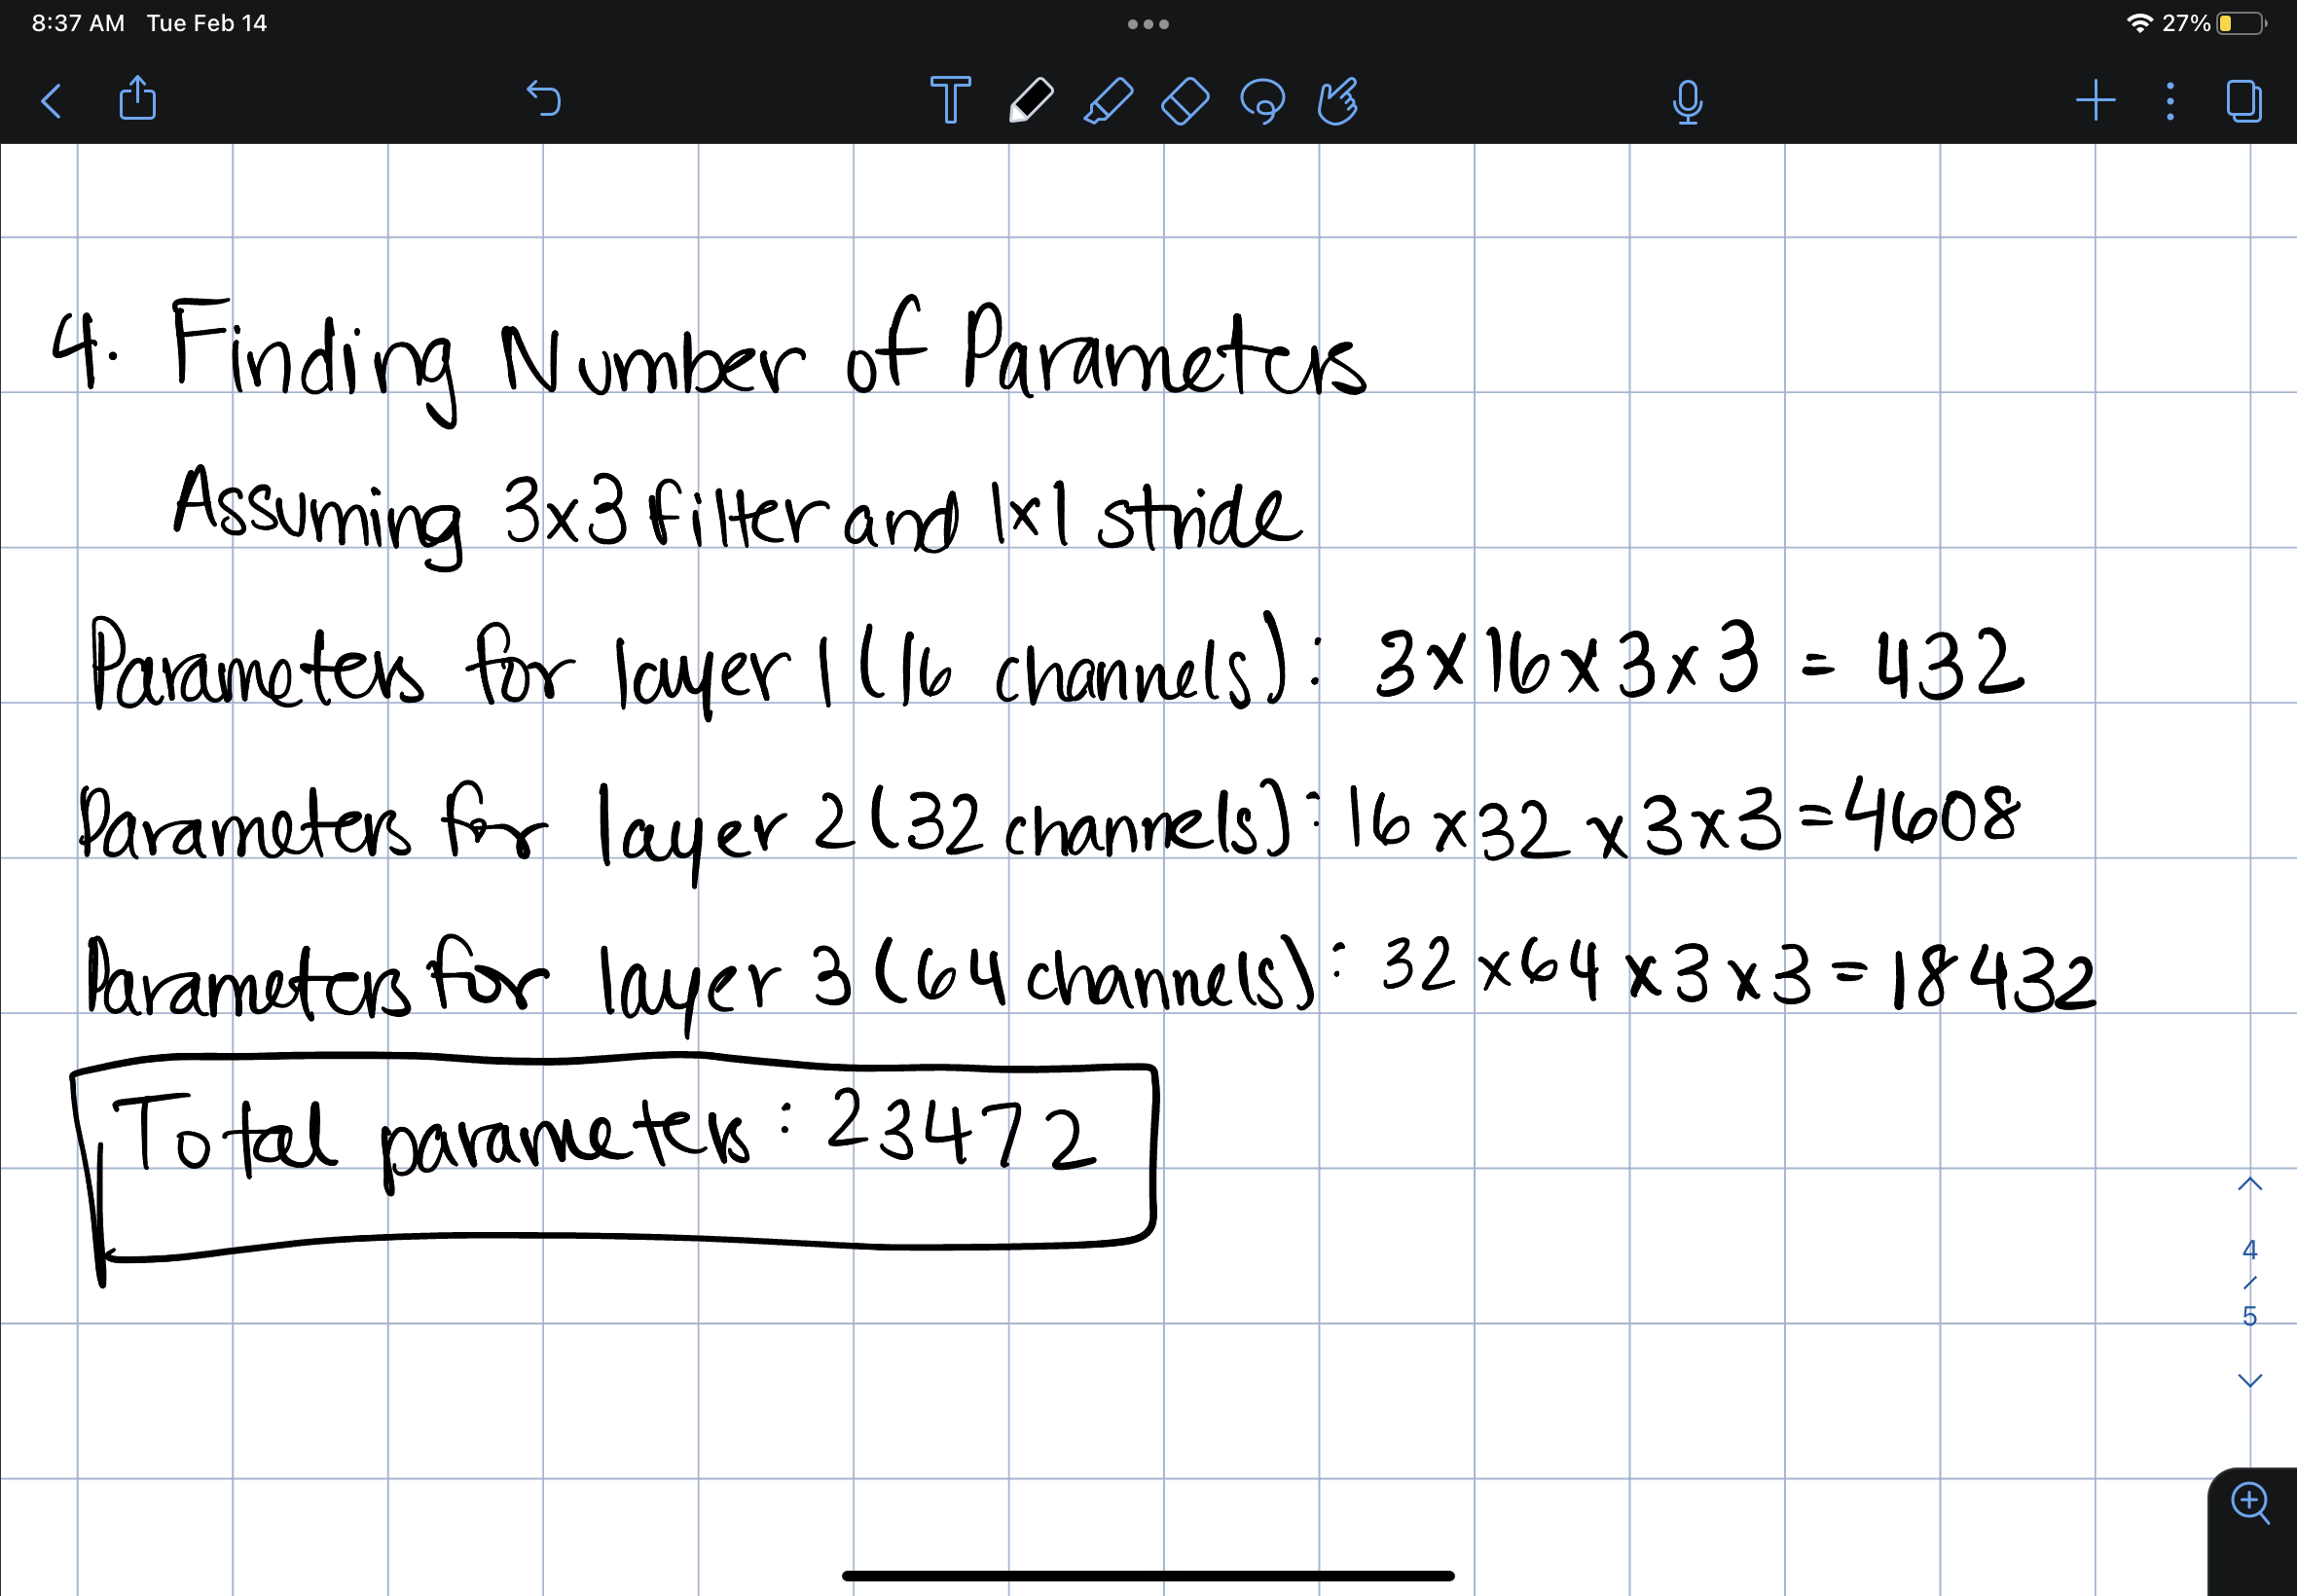

# 2. CIFAR-10 classification (3 points)

CIFAR-10 is a standard dataset where the goal is to classify 32 x 32 images into one of 10 classes. The goal of this problem is simple: build and train a convolutional neural network to perform classification on CIFAR-10. The problem is intentionally extremely open-ended! There are dozens (hundreds?) of tutorials online describing how to train a convnet on CIFAR-10 - please seek them out and make use of them. I recommend getting started with the [CIFAR-10 tutorial from PyTorch](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/cifar10_tutorial.ipynb) which includes code for loading the dataset and evaluating performance on it. You are welcome to use any other resource that you want (but please cite it!) - as I mentioned there are many, many tutorials online, and googling for help is an utterly crucial skill for a researcher! You will be graded on the final test accuracy achieved by your model:

- 60% accuracy or higher: 2/3 points
- 75% accuracy or higher: 3/3 points
- Highest accuracy in the class: 4/3 points!

Note that in order for us to know the final performance of your model, you will need to implement a function that computes the accuracy of your model on the test set (which appears in both of the linked tutorials above). The only rules are: You can only train your model on the CIFAR-10 training set (i.e. you can't use pre-trained models or other datasets for additional training, and you certaintly can't train on the CIFAR-10 test set!), and you must train the model on the free Colab GPU or TPU. This means you can only train the model for an hour or so! This is *much* less compute than is typically used for training CIFAR-10 models. As such, this is as much an exercise in building an accurate model as it is in building an efficient one. This is a popular game to play, and to the best of my knowledge the state-of-the-art is [this approach](https://myrtle.ai/learn/how-to-train-your-resnet/) which attains 96% accuracy in only *26 seconds* on a single GPU! (note that the final link on that page is broken; it should be [this](https://myrtle.ai/learn/how-to-train-your-resnet-8-bag-of-tricks/)).

There are lots of things you can try to make your model more accurate and/or more efficient:

1. Deeper models
1. Residual connections
1. [Data augmentation and normalization](https://d2l.ai/chapter_computer-vision/kaggle-cifar10.html#image-augmentation)
1. Regularization like dropout or weight decay
1. [Learning rate schedules](https://d2l.ai/chapter_optimization/lr-scheduler.html)
1. [Different forms of normalization](https://d2l.ai/chapter_convolutional-modern/batch-norm.html)

Note that we haven't covered all these topics in class yet, but you should be able to get to at least 60% accuracy without applying all of these ideas - and probably 75% by tweaking around a little bit. Specifically, you should be able to get about 60% accuracy by taking the basic AlexNet architecture we discussed in class and applying it directly to CIFAR-10. And, if you're feeling adventurous, feel free to go for 96% using the aforementioned blog series! Good luck!

I used this article: https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf 
called "ImageNet Classification with Deep Convolutional Neural Networks" as a reference and tutorial for the CNN. I also used this GitHub as a tutorial: https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-alexnet-cifar10.ipynb and added extra layers and max pooling layers to increase accuracy.

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')
import os
import time
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

Mounted at /content/drive


In [2]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [3]:
# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.005
BATCH_SIZE = 64
NUM_EPOCHS = 20

# Architecture
NUM_CLASSES = 10

# Other
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
set_all_seeds(RANDOM_SEED)


In [4]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader


# CIFAR10 dataset 
train_loader, valid_loader = get_train_valid_loader(data_dir = './data', batch_size = 64,  augment = False, random_seed = 1)

test_loader = get_test_loader(data_dir = './data', batch_size = 64)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([64, 3, 227, 227])
Image label dimensions: torch.Size([64])
tensor([4, 4, 6, 3, 6, 8, 9, 8, 0, 8])

Validation Set:
Image batch dimensions: torch.Size([64, 3, 227, 227])
Image label dimensions: torch.Size([64])
tensor([8, 2, 7, 7, 5, 8, 3, 2, 1, 1])

Testing Set:
Image batch dimensions: torch.Size([64, 3, 227, 227])
Image label dimensions: torch.Size([64])
tensor([9, 0, 5, 9, 1, 2, 5, 1, 0, 6])


In [6]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [7]:
torch.manual_seed(RANDOM_SEED)

model = AlexNet(NUM_CLASSES)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay = 0.005, momentum = 0.9)  
# Train the model
total_step = len(train_loader)

In [8]:
for epoch in range(NUM_EPOCHS):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, NUM_EPOCHS, i+1, total_step, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

Epoch [1/20], Step [704/704], Loss: 2.0642
Accuracy of the network on the 5000 validation images: 59.28 %
Epoch [2/20], Step [704/704], Loss: 1.4083
Accuracy of the network on the 5000 validation images: 66.78 %
Epoch [3/20], Step [704/704], Loss: 1.1825
Accuracy of the network on the 5000 validation images: 70.78 %
Epoch [4/20], Step [704/704], Loss: 0.1458
Accuracy of the network on the 5000 validation images: 72.8 %
Epoch [5/20], Step [704/704], Loss: 0.6046
Accuracy of the network on the 5000 validation images: 74.84 %
Epoch [6/20], Step [704/704], Loss: 0.6832
Accuracy of the network on the 5000 validation images: 77.5 %
Epoch [7/20], Step [704/704], Loss: 0.4942
Accuracy of the network on the 5000 validation images: 78.1 %
Epoch [8/20], Step [704/704], Loss: 0.4878
Accuracy of the network on the 5000 validation images: 78.62 %
Epoch [9/20], Step [704/704], Loss: 1.4144
Accuracy of the network on the 5000 validation images: 79.52 %
Epoch [10/20], Step [704/704], Loss: 0.2666
Accur

In [9]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

Accuracy of the network on the 10000 test images: 79.82 %
